In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from schedulers import LinearScheduler,CosineScheduler
from unet import UNetTimed, UNetTimedWithVAE
from schedulers import DDPM
from schedulers import DDIMSampler, DDPMSampler
from vae import VAE
from fid import FIDScore


fid_calculator = FIDScore()



mnist_dataset = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))


/home/nazara/Data2/UCU/CV_GENAI_2_3/env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nazara/Data2/UCU/CV_GENAI_2_3/env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
vae_model = VAE(latent_dim=64)
vae_model.load_state_dict(torch.load('vae_model2.pth'))
vae_model.eval()

for param in vae_model.parameters():
    param.requires_grad = False

unet = UNetTimedWithVAE(vae_model)


/tmp/ipykernel_27401/3499586809.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_model.load_state_dict(torch.load('vae_model2.pth'))


In [4]:
def sample_rect_flow(unet, batch_size, inference_steps=20, device = 'cuda'):
    x0 = torch.randn(batch_size, 1, 8, 8).to(device)
    timesteps = torch.linspace(0, 1, inference_steps).to(device)  # Go from 0 to 1
    xt = x0  # Start from pure noise

    for t in timesteps:
        # t = t.view(1, 1, 1, 1).expand(1, 1, 1, 1)  # Ensure correct shape
        with torch.no_grad():
            predicted_velocity = unet(xt, t.unsqueeze(0))  # Predict the velocity field
        xt = xt + predicted_velocity / inference_steps  # Move along the learned trajectory

    return xt

In [5]:
# Create DataLoader
batch_size = 128
dataloader = torch.utils.data.DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True,drop_last=True)

# Initialize model, optimizer and loss function
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-5)
mse_loss = torch.nn.MSELoss()

# Training hyperparameters
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet.to(device)
fid_history = []
loss_history = []
# DDPM instance

for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (images, _) in enumerate(dataloader):
        images = images.to(device)
        optimizer.zero_grad()
        
        # For reflow, we use:
        # x1: the real (clean) image from the dataset
        # x0: a noise sample from a standard Gaussian (e.g., N(0, I))
        x1 = unet.encode_vae(images)
        x0 = torch.randn_like(x1).to(device)
        
        # timesteps = torch.randint(0, num_steps, (batch_size,), device=device)
        timesteps = torch.rand((batch_size,),device=device)
        
        # The target constant velocity is: v_target = (x1 - x0)
        target_velocity = x1 - x0
        
        # Loop over discrete time steps t in [0, 1]
        # (Here, torch.linspace generates num_steps values between 0 and 1)
        # Add noise to images according to timesteps
        xt = (1 - timesteps.view(-1,1,1,1) ) * x0 + (timesteps.view(-1,1,1,1)) * x1
        
        # Predict noise
        predicted_direction = unet(xt, timesteps)
        
        # Calculate loss
        loss = mse_loss(predicted_direction, target_velocity)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch} | Batch {batch_idx} | Loss: {loss.item():.4f}')
    
    avg_loss = total_loss / len(dataloader)
    print(f'Epoch {epoch} | Average Loss: {avg_loss:.4f}')
    
    # # Optional: Save checkpoint
    # if (epoch + 1) % 10 == 0:
    #     torch.save({
    #         'epoch': epoch,
    #         'model_state_dict': unet.state_dict(),
    #         'optimizer_state_dict': optimizer.state_dict(),
    #         'loss': avg_loss,
    #     }, f'latent_ddpm_checkpoint_epoch_{epoch+1}.pt')
    with torch.no_grad():
        sample_images = sample_rect_flow(unet.eval(), batch_size, inference_steps=20, device=device)
        sample_images = unet.decode_vae(sample_images).cpu()


    # Get a batch of real images for FID calculation
    real_images = next(iter(dataloader))[0]
    real_images = real_images.to(device)

    # Compute FID score
    assert real_images.shape == sample_images.shape, f"Wrong shapes real = {real_images.shape}, sampled = {sample_images.shape}"
    fid_score = fid_calculator.calculate_fid(real_images.cpu(), sample_images.cpu())
    fid_history.append(fid_score)  # Store FID history
    loss_history.append(avg_loss)
    print(f'Epoch {epoch} | FID Score: {fid_score:.4f}')

Epoch 0 | Batch 0 | Loss: 2.1301
Epoch 0 | Batch 100 | Loss: 1.9977
Epoch 0 | Batch 200 | Loss: 1.9847
Epoch 0 | Batch 300 | Loss: 2.0280
Epoch 0 | Batch 400 | Loss: 2.0004
Epoch 0 | Average Loss: 2.0068
Epoch 0 | FID Score: 36.5747
Epoch 1 | Batch 0 | Loss: 1.9812
Epoch 1 | Batch 100 | Loss: 2.0247
Epoch 1 | Batch 200 | Loss: 1.9539
Epoch 1 | Batch 300 | Loss: 1.7222
Epoch 1 | Batch 400 | Loss: 1.6545
Epoch 1 | Average Loss: 1.8538
Epoch 1 | FID Score: 43.3391
Epoch 2 | Batch 0 | Loss: 1.6488
Epoch 2 | Batch 100 | Loss: 1.6568
Epoch 2 | Batch 200 | Loss: 1.6429
Epoch 2 | Batch 300 | Loss: 1.5741
Epoch 2 | Batch 400 | Loss: 1.6410
Epoch 2 | Average Loss: 1.6368
Epoch 2 | FID Score: 43.5923
Epoch 3 | Batch 0 | Loss: 1.6125
Epoch 3 | Batch 100 | Loss: 1.5254
Epoch 3 | Batch 200 | Loss: 1.6398
Epoch 3 | Batch 300 | Loss: 1.5672
Epoch 3 | Batch 400 | Loss: 1.5339
Epoch 3 | Average Loss: 1.6041
Epoch 3 | FID Score: 38.1763
Epoch 4 | Batch 0 | Loss: 1.5626
Epoch 4 | Batch 100 | Loss: 1.6038


KeyboardInterrupt: 

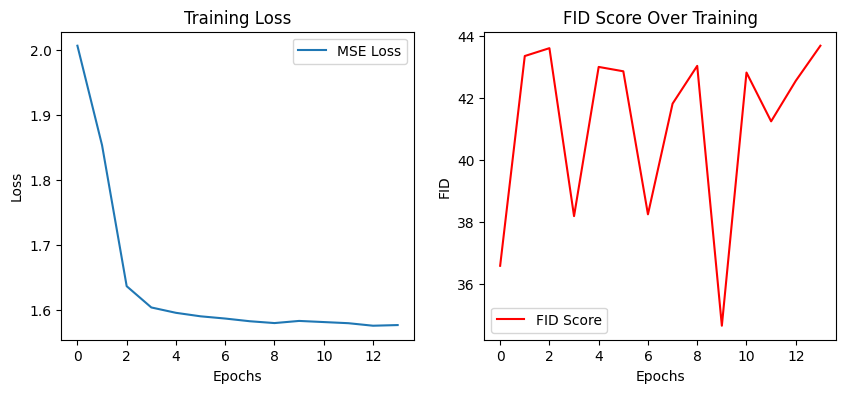

In [20]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label="MSE Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fid_history, label="FID Score", color='r')
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.title("FID Score Over Training")
plt.legend()

plt.show()

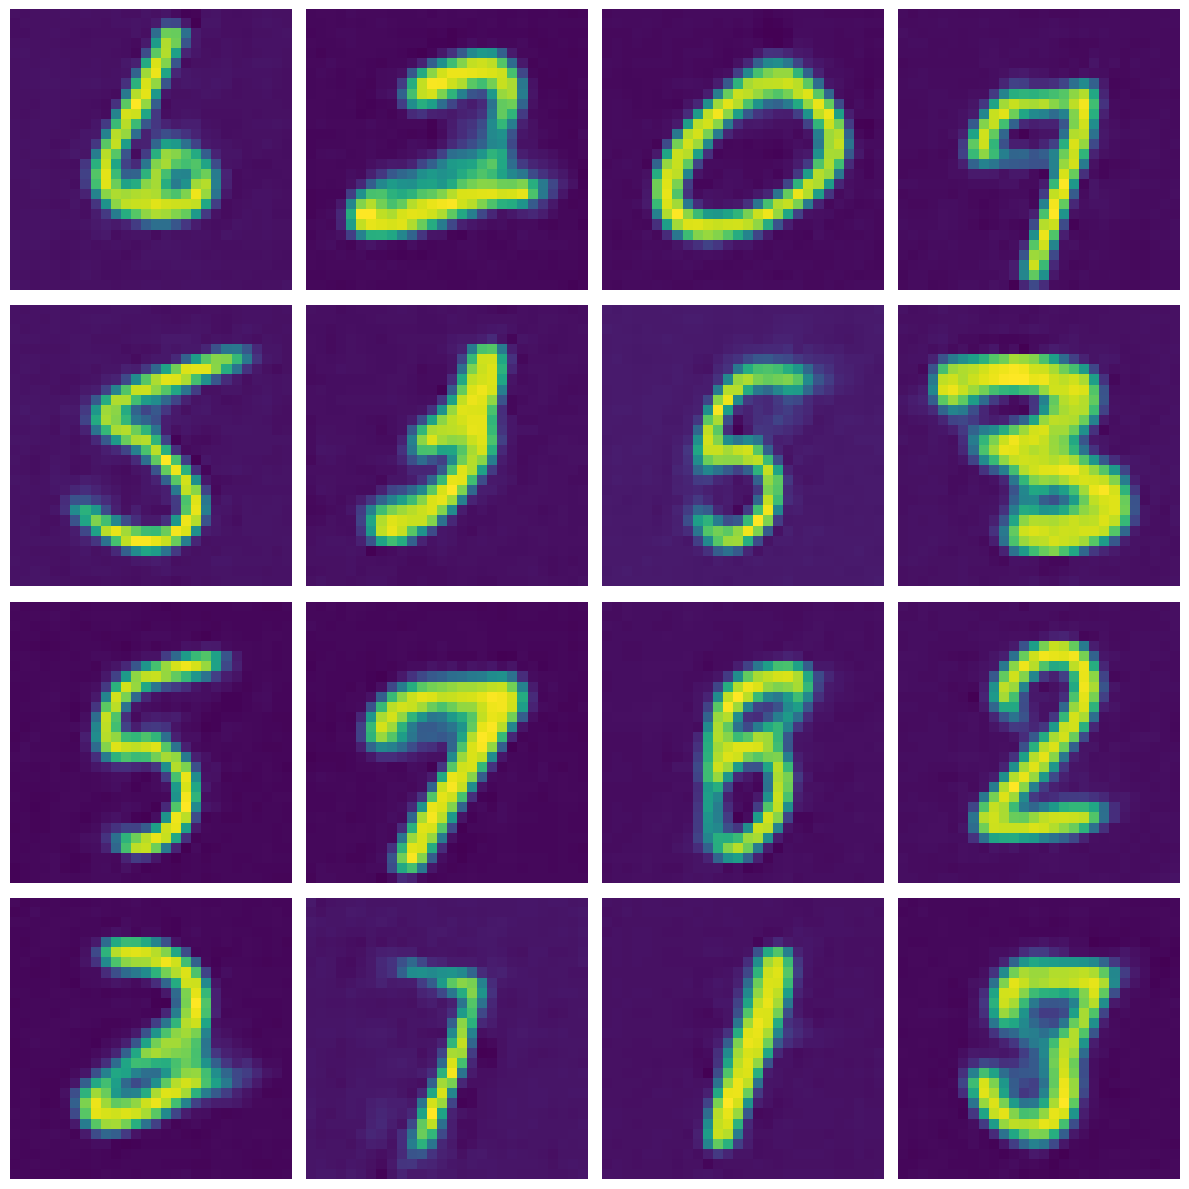

In [19]:
# Set the model to evaluation mode
unet.eval()
# Generate random noise as starting point (x0)
x0 = torch.randn(16, 1, 8, 8).to(device)

# Define number of inference steps (e.g., 10, 20, or 50 instead of 1000)
num_inference_steps = 50  # Much fewer steps than diffusion
timesteps = torch.linspace(0, 1, num_inference_steps).to(device)  # Go from 0 to 1

xt = x0  # Start from pure noise

for t in timesteps:
    # t = t.view(1, 1, 1, 1).expand(1, 1, 1, 1)  # Ensure correct shape
    with torch.no_grad():
        predicted_velocity = unet(xt, t.unsqueeze(0))  # Predict the velocity field
    xt = xt + predicted_velocity / num_inference_steps  # Move along the learned trajectory

#decode latent to image
with torch.no_grad():
    denoised_image = unet.decode_vae(xt)

# Convert to numpy for visualization
denoised_image = denoised_image.squeeze().cpu().detach().numpy()

# Visualize
# Create a figure with subplots
plt.figure(figsize=(12, 12))

# Plot each sample
for i in range(16):
    plt.subplot(4, 4, i + 1)
    # Remove channel dimension and move tensor to CPU
    img = denoised_image[i]
    # Plot image
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()